## Setup

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.utils.mem import *
from fastai.callbacks import *

import os
import torchvision
from torchvision.utils import save_image

from torchvision.models import vgg16_bn

In [6]:
import DAT259.setup as setup
import DAT259.wgan as wgan
import DAT259.superresgan as superres
import DAT259.segmentation as seg

In [7]:
path_mask = 'data/ISIC2018_Task1_Training_GroundTruth'
path_img = 'data/ISIC2018_Task1-2_Training_Input'

## Create testset

In [5]:
setup.create_testset(path_img, path_mask, 500)

## Generate masks

In [6]:
file_names = setup.choose_data(Path(path_mask), 100)

wgan.generate_masks(file_names, 100, path_mask, 1, bs=50) 

In [7]:
path_gen_masks = 'data/generated_mask_100'
wgan.image_cleaner(path_gen_masks)

## Pretraining

In [14]:
file_names = setup.get_data(Path('data/csv/csv_100'))
path_mask = Path(path_mask)
path_img = Path(path_img)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.374093,178.095947,32.130165,1.491481,3.081820,0.260170,40.022964,100.459747,0.649600,00:30


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,69.763855,4.534272,0.894208,0.334466,0.422618,0.135752,1.028342,1.568240,0.150646,00:27


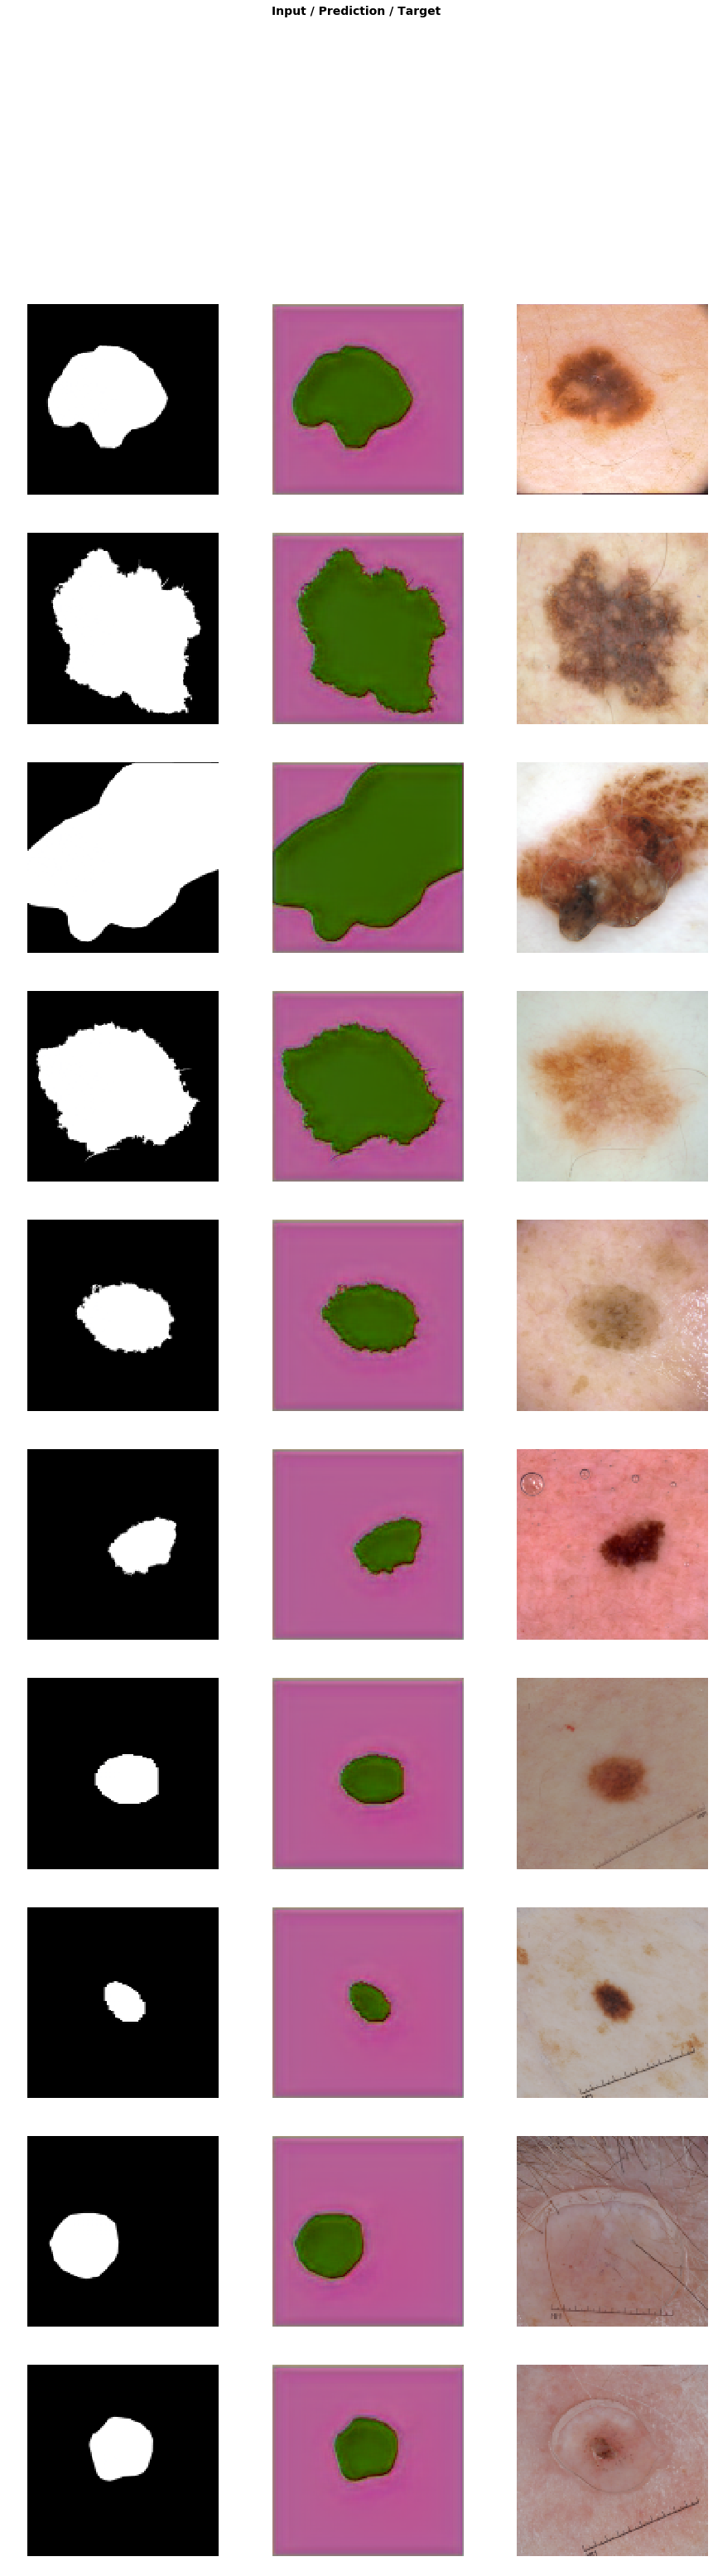

In [9]:
learn = superres.train_generator(file_names, path_mask, path_img, num_epochs=1)

In [10]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
superres.train_critic(100, num_epochs=1)

ImageDataBunch;

Train: LabelList (162 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
gen_l1_100,gen_l1_100,gen_l1_100,gen_l1_100,gen_l1_100
Path: data;

Valid: LabelList (18 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
gen_l1_100,gen_l1_100,ISIC2018_Task1-2_Training_Input,gen_l1_100,ISIC2018_Task1-2_Training_Input
Path: data;

Test: None


epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,1.466699,0.474408,0.820000,00:16


## Train GAN

In [11]:
file_names = setup.get_data(Path('data/csv/csv_100'))

ImageDataBunch;

Train: LabelList (180 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth
Path: data;

Valid: LabelList (20 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1_Training_GroundTruth,ISIC2018_Task1-2_Training_Input,ISIC2018_Task1-2_Training_Input
Path: data;

Test: None
ImageDataBunch;

Train: LabelList (90 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Pat

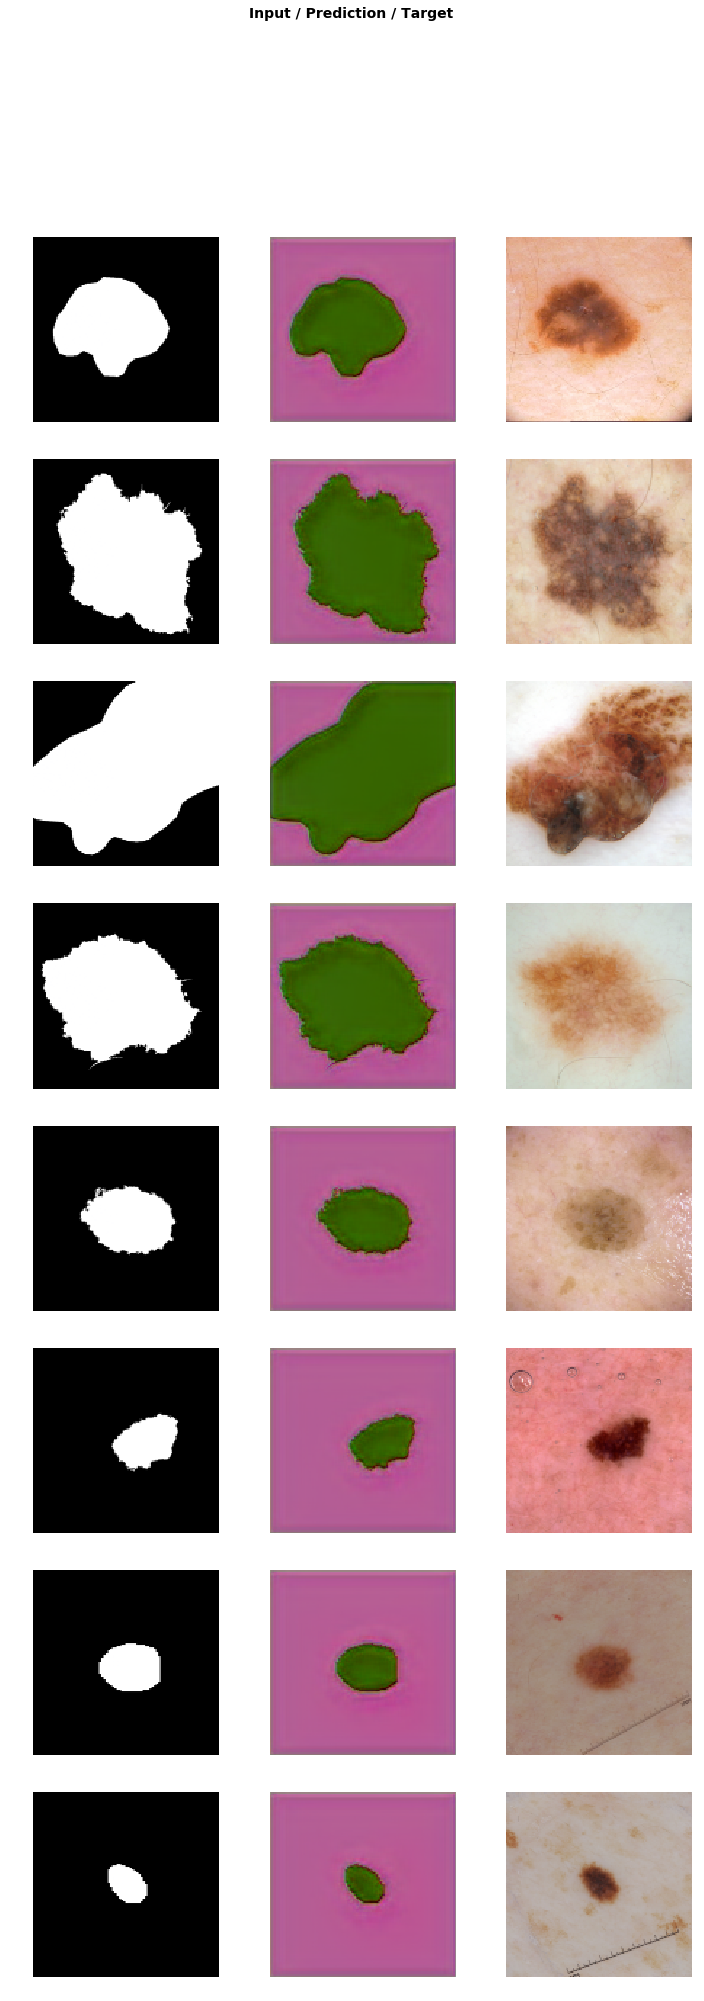

In [12]:
learn_generator = superres.train_gan(file_names, path_mask, path_img, num_epochs=1)

In [13]:
path_mask = Path('data/generated_mask_100')
path_gen = Path('data/generated_img_100')
superres.pred_gan(learn_generator, path_mask, path_gen, 100)

## Segmentation

Preparing testset

In [12]:
#images
img_size = 128
folder_name = 'test_img'
from_path = 'data/' + folder_name + '/'
to_path = 'data/' + str(img_size) + 'x' + str(img_size) + '/' + folder_name + '/'

seg.resize_img_folder(from_path, to_path, img_size, folder_name)

In [13]:
#masks
img_size = 128
folder_name = 'test_mask'
from_path = 'data/' + folder_name + '/'
to_path = 'data/' + str(img_size) + 'x' + str(img_size) + '/' + folder_name + '/'

seg.resize_img_folder(from_path, to_path, img_size, folder_name)

### Experiment1

In [19]:
the_list = [100]

for i in the_list:
    num_of_org_data = str(i)
    print(num_of_org_data)

    # loop for segmentation using different amount of generated data 
    from_ISIC = setup.get_data(Path('data/csv/csv_' + num_of_org_data))
    path = 'data/'
    gen_img_folder = 'generated_img_'+ num_of_org_data
    gen_mask_folder = 'generated_mask_' + num_of_org_data
    test_list = [100, 0]

    for i in range(len(test_list)):

        # creating dataframes for the orginal dataset and the generated data
        number_of_generated_data = test_list[i]
        df = seg.merge_df(path, gen_img_folder, gen_mask_folder, from_ISIC, number_of_generated_data)

        # creating data for model training
        data = seg.data_mix(path, df)

        #create learner
        learner = seg.create_learner(data)

        #Training and saving the segmentation model
        model_name = 'seg_'+ num_of_org_data+ '_' + str(number_of_generated_data)
        if (os.path.isdir('data/models/segmentation_models')==False): os.mkdir('data/models/segmentation_models')
        if (os.path.isdir('data/models/segmentation_models/' + num_of_org_data)==False): os.mkdir('data/models/segmentation_models/' + num_of_org_data)
        #Se på dette!
        if (os.path.isdir('data/predictions')==False): os.mkdir('data/predictions')
        if (os.path.isdir('data/predictions/' + num_of_org_data)==False): os.mkdir('data/predictions/' + num_of_org_data)
        full_model_path = 'segmentation_models/' + num_of_org_data + '/' + model_name
        #if (os.path.isdir(full_model_path)==False): os.mkdir(full_model_path)
        seg.seg_model(learner, full_model_path)
#gradient y=ax+b
        # prediction and saving them 
        save_pred_at = 'data/predictions/' + num_of_org_data + '/' + str(number_of_generated_data) + '/'
        if (os.path.isdir(save_pred_at)==False): os.mkdir(save_pred_at)
        seg.predict_on_test_data(learner, save_pred_at)

100


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.752431,0.174507,0.506460,0.595042,00:13


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.186803,0.106366,0.505484,0.655032,00:13


500
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.880973,0.378804,0.524118,0.297787,00:13


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.412005,0.308526,0.481314,0.665552,00:11


500
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


In [24]:
org = [100]
gen = [100, 0]
df10 = pd.DataFrame(columns = gen, index = org);
for i in org:
    for j in gen:
        df10[j][i] = seg.dice_score('data/predictions/'+ str(i)+ '/' + str(j), 'data/128x128/test_mask');

In [25]:
df10

,100,0
100,0.695312,0.66241


In [26]:
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
if (os.path.isdir('data/results')==False): os.mkdir('data/results')
df10.to_csv('data/results/' + str(date))

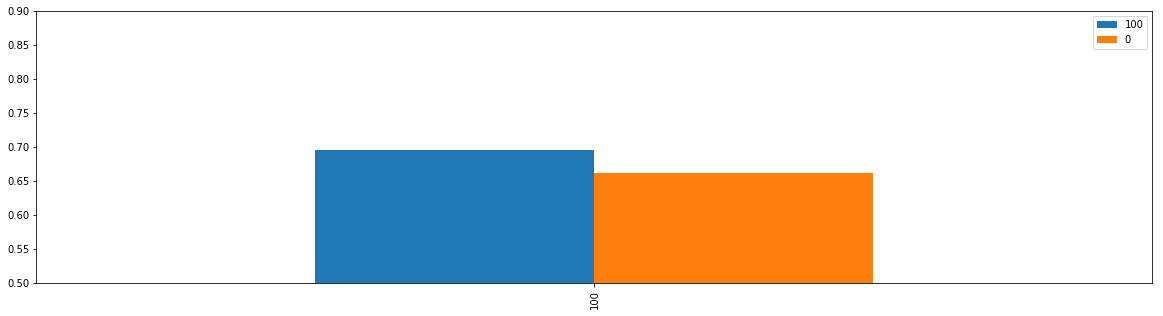

In [27]:
df10.plot(kind='bar', figsize = (20,5), ylim=(0.5,0.9))